In [2]:
#data
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import pandas as pd
import pathlib
import seaborn as sns
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

#model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

#optimize_model
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import sys

In [3]:
data_path = '../data/'
width = 16
height = 16

In [4]:
def clear(img):
    """
    convert img to specific format (width,height) in RGB .jpg
    """
    if img.size != (width, height) :
        img = img.resize((width, height))
    if img.mode != 'RGB':
        img = img.convert('RGB')

    return img

In [5]:
labels = {'agricultural' : 0, 
          'airport' : 1, 
          'beach' : 2, 
          'chaparral' : 3, 
          'city' : 4, 
          'cloudy' : 5, 
          'desert' : 6, 
          'forest' : 7, 
          'harbor' : 8, 
          'parking' : 9, 
          'river' : 10, 
          'roads' : 11, 
          'storage' : 12, 
          'water' : 13}

In [6]:
image_list, label_list = [], []

for folder in os.listdir(data_path):
    for file in os.listdir(data_path + folder):
        img = Image.open(data_path + folder +'/'+file)
        img = clear(img)
        image_list.append(img_to_array(img))
        label_list.append(labels[folder])

X_train, X_test, y_train, y_test = train_test_split(image_list,
                                                    label_list,
                                                    test_size = 0.1,
                                                    random_state = 42,
                                                    stratify = label_list)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size = 0.1,
                                                  random_state = 42,
                                                  stratify = y_train)

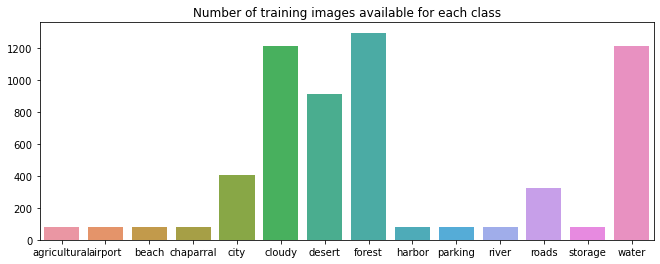

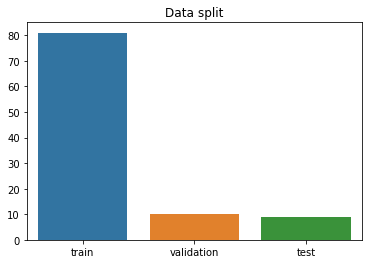

Total number of img in the dataset: 7431


In [16]:
label_names = ["agricultural", 
               "airport", 
               "beach", 
               "chaparral", 
               "city", 
               "cloudy",
               "desert", 
               "forest", 
               "harbor", 
               "parking", 
               "river", 
               "roads", 
               "storage", 
               "water"]

plt.figure(figsize=(11,4))
unique, counts = np.unique(y_train, return_counts=True)
sns.barplot(x = label_names, y = counts )
plt.title('Number of training images available for each class')

plt.show()

data_type = ["train","validation","test"]
perc = [81,10,9]
sns.barplot(x = data_type, y = perc )
plt.title('Data split')

plt.show()

print("Total number of img in the dataset:", len(y_train)+len(y_val)+len(y_test))

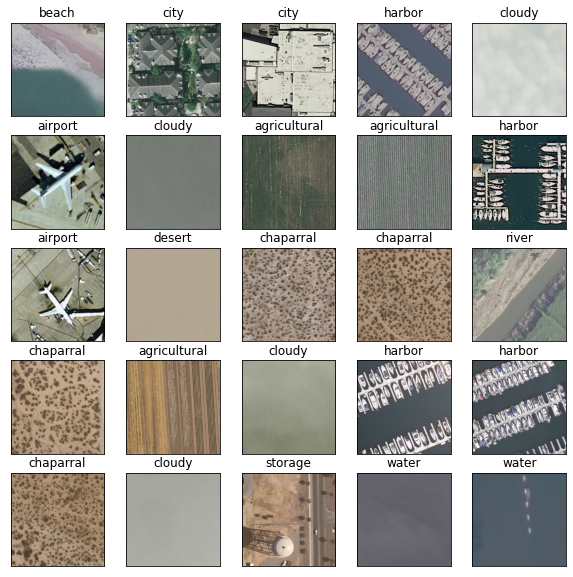

In [17]:
plt.figure(figsize=(10,10))
data_dir = pathlib.Path(data_path)
for i in range(25):
    plt.subplot(5,5,i+1)
    random_class = random.choice(label_names)
    img = plt.imread(random.choice(list(data_dir.glob(random_class+"/*.jpg"))))
    plt.xticks([])
    plt.yticks([])
    plt.title(random_class)
    plt.imshow(img)
plt.show()

In [18]:
X_train = np.array(X_train)/255
X_val = np.array(X_val)/255
X_test = np.array(X_test)/255

lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_val = lb.fit_transform(y_val)
y_test = lb.fit_transform(y_test)

### CNN model

In [42]:
model = Sequential()

model.add(Conv2D(20,(3,3),strides = 2,activation = 'relu',padding = 'valid',input_shape=(width,height,3)))
model.add(Conv2D(20,(3,3),strides = 2,activation = 'relu',padding = 'same'))

model.add(MaxPooling2D(2,2))
model.add(Flatten()) 

model.add(Dense(56,activation = 'relu'))
# model.add(Dense(28,activation = 'relu'))
model.add(Dense(14,activation = 'softmax'))  

model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50 (Conv2D)          (None, 7, 7, 20)          560       
                                                                 
 conv2d_51 (Conv2D)          (None, 4, 4, 20)          3620      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 2, 2, 20)         0         
 g2D)                                                            
                                                                 
 flatten_25 (Flatten)        (None, 80)                0         
                                                                 
 dense_75 (Dense)            (None, 56)                4536      
                                                                 
 dense_76 (Dense)            (None, 14)                798       
                                                     

In [43]:
callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.01,
    patience=2,
    verbose=1)

model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate=0.0007372472369223287), metrics=['accuracy'])

epochs = 41

history = model.fit(X_train, y_train, epochs = epochs, validation_data = (X_val, y_val)) #callbacks = [callback])

Epoch 1/41
189/189 [==============================] - 5s 14ms/step - loss: 1.6943 - accuracy: 0.4207 - val_loss: 1.2199 - val_accuracy: 0.5217
Epoch 2/41
189/189 [==============================] - 2s 11ms/step - loss: 1.1572 - accuracy: 0.6025 - val_loss: 1.0835 - val_accuracy: 0.6637
Epoch 3/41
189/189 [==============================] - 2s 8ms/step - loss: 1.0114 - accuracy: 0.6720 - val_loss: 0.9915 - val_accuracy: 0.6816
Epoch 4/41
189/189 [==============================] - 1s 8ms/step - loss: 0.8900 - accuracy: 0.7094 - val_loss: 0.8522 - val_accuracy: 0.7175
Epoch 5/41
189/189 [==============================] - 1s 7ms/step - loss: 0.8171 - accuracy: 0.7272 - val_loss: 0.8182 - val_accuracy: 0.7115
Epoch 6/41
189/189 [==============================] - 1s 7ms/step - loss: 0.7866 - accuracy: 0.7376 - val_loss: 0.7740 - val_accuracy: 0.7235
Epoch 7/41
189/189 [==============================] - 1s 7ms/step - loss: 0.7692 - accuracy: 0.7413 - val_loss: 0.7651 - val_accuracy: 0.7459
Epoc

24/24 - 0s - loss: 0.5871 - accuracy: 0.7917 - 139ms/epoch - 6ms/step
0.7916666865348816


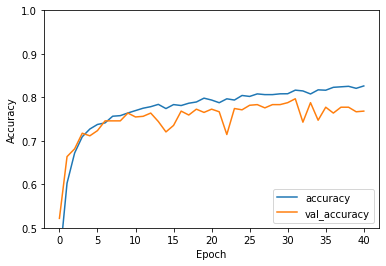

In [44]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print(test_acc)
plt.show()

In [33]:
space = {'lr' : hp.loguniform('lr', np.log(0.0001), np.log(0.01)),
         'nb_epochs' :  hp.quniform('nb_epochs', 1, 50, 1),
#          'size_Dense_1'
        }

In [34]:
def f_nn(params):
    
    model = Sequential()

    model.add(Conv2D(20,(3,3),strides = 2,activation = 'relu',padding = 'valid',input_shape=(width,height,3)))
    model.add(Conv2D(20,(3,3),strides = 2,activation = 'relu',padding = 'same'))

    model.add(MaxPooling2D(2,2))
    model.add(Flatten()) 
    

    model.add(Dense(56,activation = 'relu')) 
    model.add(Dense(28,activation = 'relu'))
    model.add(Dense(14,activation = 'softmax'))  
    
#     callback = EarlyStopping(monitor="val_loss", min_delta=0.01, patience=2, verbose=0)

    model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate=params['lr']), metrics=['accuracy'])

    history = model.fit(X_train, 
                        y_train, 
                        epochs = int(params['nb_epochs']), 
                        validation_data = (X_val, y_val), 
                        verbose = 0)
#                         callbacks = [callback])

    pred_auc = model.predict(X_val, batch_size = 128, verbose = 0)
    acc = roc_auc_score(y_val, pred_auc)
#     print('AUC:', acc, 'lr:', params['lr'])
    sys.stdout.flush() 
    return {'loss': -acc, 'status': STATUS_OK}

In [35]:
trials = Trials()
best = fmin(f_nn, space, algo=tpe.suggest, max_evals=20, trials=trials)
print('best: ', best)

100%|██████████| 20/20 [13:37<00:00, 40.87s/trial, best loss: -0.9737658263720042]
best:  {'lr': 0.0007372472369223287, 'nb_epochs': 41.0}


In [ ]:
# from keras.models import Sequential
#     from keras.layers.core import Dense, Dropout, Activation
#     from keras.optimizers import Adadelta, Adam, rmsprop

#     print ('Params testing: ', params)
#     model = Sequential()
#     model.add(Dense(output_dim=params['units1'], input_dim = X.shape[1])) 
#     model.add(Activation(params['activation']))
#     model.add(Dropout(params['dropout1']))

#     model.add(Dense(output_dim=params['units2'], init = "glorot_uniform")) 
#     model.add(Activation(params['activation']))
#     model.add(Dropout(params['dropout2']))

#     if params['choice']['layers']== 'three':
#         model.add(Dense(output_dim=params['choice']['units3'], init = "glorot_uniform")) 
#         model.add(Activation(params['activation']))
#         model.add(Dropout(params['choice']['dropout3']))    

#     model.add(Dense(1))
#     model.add(Activation('sigmoid'))
#     model.compile(loss='binary_crossentropy', optimizer=params['optimizer'])

#     model.fit(X, y, nb_epoch=params['nb_epochs'], batch_size=params['batch_size'], verbose = 0)

In [41]:
y_pred = model.predict(X_test)

Y_pred = []
Y_Test = []
for i in range(len(y_pred)):
    Y_pred.append(np.argmax(y_pred[i]))
    Y_Test.append(np.argmax(y_test[i]))
    
print(classification_report(Y_Test, Y_pred))

24/24 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.12      0.10      0.11        10
           2       1.00      0.50      0.67        10
           3       0.67      1.00      0.80        10
           4       0.53      0.82      0.65        50
           5       0.75      0.82      0.78       150
           6       0.87      0.97      0.92       114
           7       0.81      0.96      0.88       160
           8       0.75      0.30      0.43        10
           9       0.00      0.00      0.00        10
          10       0.57      0.40      0.47        10
          11       0.62      0.38      0.47        40
          12       0.00      0.00      0.00        10
          13       0.97      0.76      0.85       150

    accuracy                           0.78       744
   macro avg       0.55      0.50      0.50       744
weighted avg       0.76    

C:\Users\eloua\anaconda3\envs\sat\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\eloua\anaconda3\envs\sat\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\eloua\anaconda3\envs\sat\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix:
[[  0   0   0   1   0   8   1   0   0   0   0   0   0   0]
 [  0   1   0   0   6   2   0   0   0   0   0   1   0   0]
 [  0   0   5   0   0   5   0   0   0   0   0   0   0   0]
 [  0   0   0  10   0   0   0   0   0   0   0   0   0   0]
 [  0   1   0   2  41   5   0   0   0   0   1   0   0   0]
 [  2   2   0   1   1 123  16   3   0   0   1   1   0   0]
 [  0   0   0   0   0   3 111   0   0   0   0   0   0   0]
 [  0   0   0   0   0   3   0 154   0   0   0   0   0   3]
 [  0   0   0   0   4   0   0   0   3   0   1   2   0   0]
 [  0   0   0   0   6   0   0   0   0   0   0   4   0   0]
 [  0   2   0   0   0   3   0   0   0   0   4   1   0   0]
 [  0   1   0   1  11  11   0   0   1   0   0  15   0   0]
 [  0   1   0   0   8   1   0   0   0   0   0   0   0   0]
 [  1   0   0   0   0   1   0  34   0   0   0   0   0 114]]


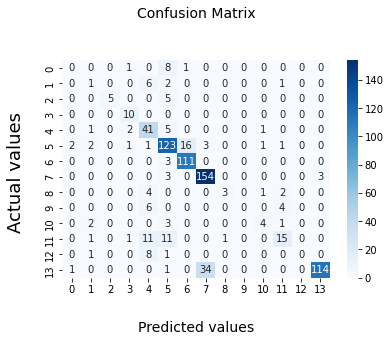

In [40]:
cf_matrix = confusion_matrix(Y_Test, Y_pred)

categories  = ["agricultural", 
               "airport", 
               "beach", 
               "chaparral", 
               "city", 
               "cloudy",
               "desert", 
               "forest", 
               "harbor", 
               "parking", 
               "river", 
               "roads", 
               "storage", 
               "water"]

print("Confusion Matrix:")

print(cf_matrix)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt="d")

ax.set_title('Confusion Matrix\n\n',fontdict = {'size':14}, pad = 10)
ax.set_xlabel('\nPredicted values',fontdict = {'size':14}, labelpad = 10)
ax.set_ylabel('Actual values ',fontdict = {'size':18}, labelpad = 20);

## Display the visualization of the Confusion Matrix.
plt.show()